In [3]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import pickle

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [6]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

X_test_estimated_a_processed.shape = (720, 48), X_test_estimated_b_processed.shape = (720, 48), X_test_estimated_c_processed.shape = (720, 48)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,direct_rad_cloud_interaction,modified_solar_elevation_squared,is_freezing,is_snow,is_rain
0,15.2,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.53125,271.225006,872357.56250,54.224998,1.0,0.0,0.0,0.0,1007.500000,0.0,0.0,72.375000,92.172501,0.00,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0.0,0.548142,1,366.725006,12415.325195,0.675033,0,0,0
1,13.7,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.68750,5.800000,11749.87500,99.675003,1.0,0.0,0.0,0.0,1001.400024,0.0,0.1,80.699997,236.257751,0.10,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0.0,0.996750,1,151.325012,1.884982,0.781978,0,0,0
2,10.5,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.65625,65.099998,135992.90625,23.299999,1.0,0.0,0.0,0.0,1006.849976,0.0,0.0,59.049999,85.390503,0.00,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0.0,0.535017,0,107.300003,4993.169922,0.405168,0,0,0
3,6.3,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.00000,0.000000,0.00000,99.574997,0.0,1.0,0.0,0.0,992.949951,0.0,0.0,93.650002,127.701752,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0.0,0.995999,1,0.000000,0.000000,0.000000,0,0,0
4,6.3,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.00000,0.000000,0.00000,49.400002,0.0,1.0,0.0,0.0,1012.200012,0.0,0.0,81.649994,346.724243,0.00,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0.0,0.499874,1,0.000000,0.000000,0.000000,0,0,0


In [7]:
x_whole.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,direct_rad_cloud_interaction,modified_solar_elevation_squared,is_freezing,is_snow,is_rain
count,87876.000000,87876.000000,8.787600e+04,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,8.787600e+04,87876.000000,8.787600e+04,87876.000000,87876.000000,87876.000000,87876.000000,87876.00000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.00000,87876.000000,87876.000000,87876.000000,87876.000000,8.787600e+04,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000,87876.000000
mean,6.000740,1.255452,5.019473e+05,139.332840,1614.441772,0.006668,275.218262,38.113689,1.374084e+05,49.413593,1.779632e+05,66.971428,0.468114,0.580397,0.005665,0.08351,1001.864807,0.787376,0.009458,73.677689,179.748642,0.056354,279.433075,73.622925,33139.296875,3.027108,0.626259,0.699240,0.000003,0.387432,0.32646,0.286108,0.028795,0.086506,-0.004858,1.446931e-02,5826.104004,0.146982,0.157935,3.421718,0.863166,0.802108,87.527275,2887.395264,0.240888,0.143293,0.117120,0.095316
std,2.686252,0.036527,8.176212e+05,227.683746,1795.061523,0.239632,6.772706,60.296883,2.145631e+05,112.954361,4.014418e+05,34.335323,0.484931,0.481037,0.029041,0.32559,13.049394,5.441632,0.041032,14.238101,97.998314,0.105411,6.484896,34.108856,17904.195312,1.748055,2.790449,1.874803,0.006012,0.487167,0.46892,0.451943,0.712333,0.695902,0.708948,7.051033e-01,14294.462891,0.218858,0.260523,9.446170,0.234743,0.398413,155.820511,8445.789062,0.298255,0.350373,0.321565,0.293653
min,0.500000,1.139250,0.000000e+00,0.000000,0.000000,-1.000000,247.425003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,935.750000,0.000000,0.000000,19.575001,6.983000,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000,0.000000,0.00000,0.000000,-0.999999,-0.999979,-1.000000,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.025000,1.230500,0.000000e+00,0.000000,487.643745,0.000000,270.774994,0.000000,0.000000e+00,0.000000,0.000000e+00,41.724998,0.000000,0.000000,0.000000,0.00000,993.775024,0.000000,0.000000,64.250000,93.872814,0.000000,274.950012,52.943750,17024.987793,1.675000,-1.400000,-0.550000,0.000000,0.000000,0.00000,0.000000,-0.689796,-0.576069,-0.707107,-7.071068e-01,0.000000,0.000000,0.000000,0.000000,0.812590,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.450000,1.255000,4.455350e+03,0.100000,1072.587524,0.000000,274.975006,0.050000,6.232850e+03,0.000000,0.000000e+00,79.800003,0.250000,1.000000,0.000000,0.00000,1002.750000,0.000000,0.000000,76.025002,180.042503,0.000000,278.674988,93.074997,36960.425781,2.700000,0.250000,0.750000,0.000000,0.000000,0.00000,0.000000,0.068755,0.159513,0.000000,6.123234e-17,0.000000,0.000000,0.000000,0.000000,0.992492,1.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.800000,1.278500,7.473542e+05,199.899994,1977.562531,0.000000,280.450012,62.474998,2.240413e+05,25.799999,1.009808e+05,98.625000,1.000000,1.000000,0.000000,0.00000,1010.925049,0.

In [24]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0
reg_models = []

def compute_sample_weight(data):
    # Assign weight of 2 for estimated data and 1 for observed data
    return np.where(data['time_since_prediction'] > 0, 2, 1)

for train_index, test_index in kf.split(x_whole):
    reg = CatBoostRegressor(
        iterations=10000000,
        depth=8,
        learning_rate=0.001,
        loss_function='MAE',
        verbose=200
    )
    
    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    # Compute sample weights for training and testing data
    train_weight = compute_sample_weight(X_train)
    test_weight = compute_sample_weight(X_test)

    # Create Pool for training and testing
    train_pool = Pool(data=X_train, label=y_train, weight=train_weight)
    test_pool = Pool(data=X_test, label=y_test, weight=test_weight)

    # Fit the model using the sample weights
    reg.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

    reg_models.append(reg)
    predictions = reg.predict(test_pool)
    
    # Compute weighted MAE manually
    weighted_mae = np.sum(test_weight * np.abs(y_test - predictions)) / np.sum(test_weight)
    total_mae += weighted_mae
    
    print(f"Fold {len(reg_models)}, Weighted Mean Absolute Error: {weighted_mae}")

average_mae = total_mae / num_folds
print(f"Average Weighted Mean Absolute Error: {average_mae}")

0:	learn: 320.5398860	test: 306.3733751	best: 306.3733751 (0)	total: 26.1ms	remaining: 3d 31m 6s
200:	learn: 282.0430685	test: 269.1414979	best: 269.1414979 (200)	total: 4.41s	remaining: 2d 12h 56m 45s
400:	learn: 245.4458956	test: 233.9429249	best: 233.9429249 (400)	total: 8.61s	remaining: 2d 11h 37m 5s
600:	learn: 214.1894337	test: 204.2124765	best: 204.2124765 (600)	total: 12.9s	remaining: 2d 11h 49m 5s
800:	learn: 189.4211306	test: 180.6785330	best: 180.6785330 (800)	total: 17.2s	remaining: 2d 11h 32m 12s
1000:	learn: 169.6866865	test: 161.9774757	best: 161.9774757 (1000)	total: 21.3s	remaining: 2d 11h 3m 5s
1200:	learn: 154.0972473	test: 147.2906951	best: 147.2906951 (1200)	total: 25.7s	remaining: 2d 11h 27m 8s
1400:	learn: 142.3893316	test: 136.2878831	best: 136.2878831 (1400)	total: 30.4s	remaining: 2d 12h 18m 43s
1600:	learn: 133.2266155	test: 127.6904906	best: 127.6904906 (1600)	total: 34.8s	remaining: 2d 12h 22m 26s
1800:	learn: 125.7341788	test: 120.5874099	best: 120.5874099

In [25]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


In [26]:
y_pred_val_obs_combined = multi_predict(x_whole_obs, reg_models)
y_pred_val_est_combined = multi_predict(x_whole_est, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_whole_obs, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_whole_est, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  60.89862630669085
MAE on validation estimated data:  55.175775252696255


# Visualization

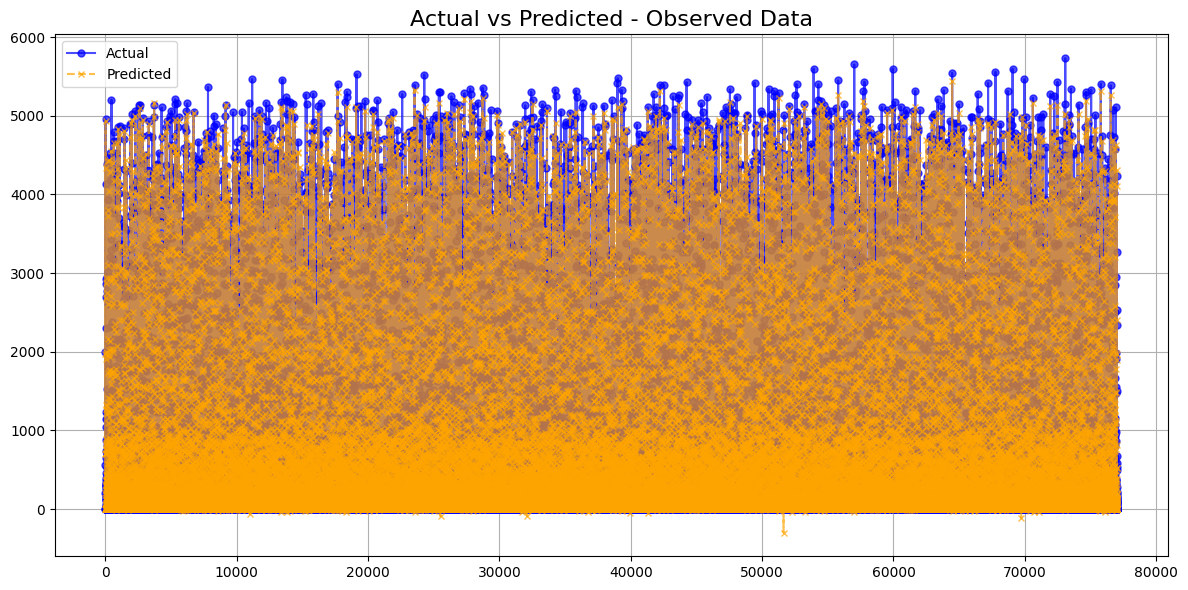

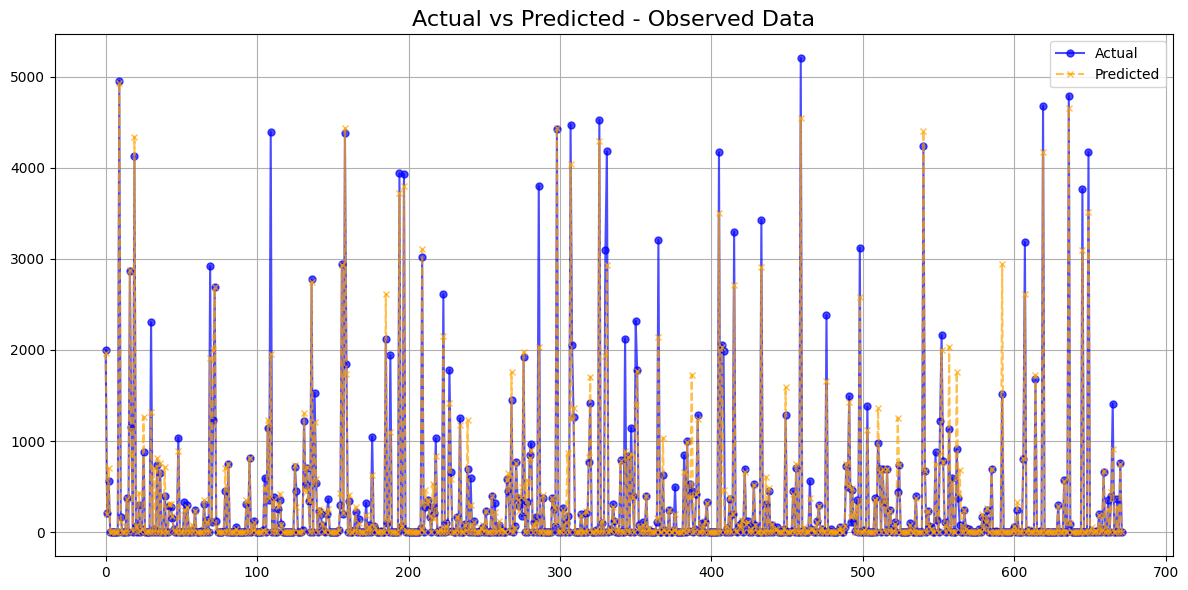

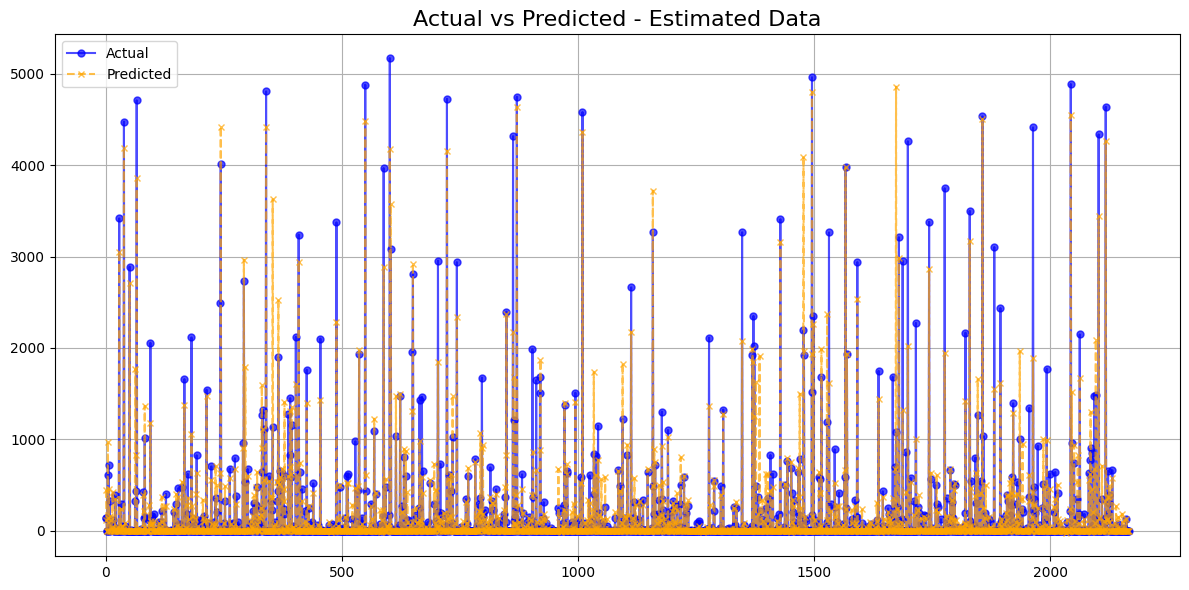

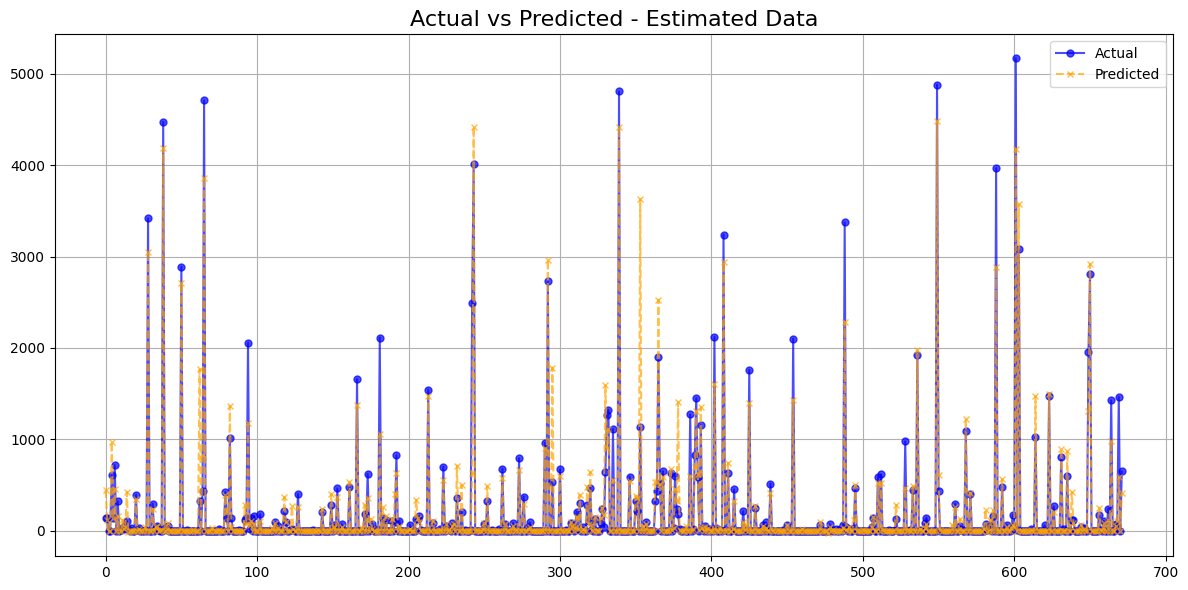

In [27]:
import matplotlib.pyplot as plt

train_prediction = multi_predict(x_whole, reg_models)

test_prediction = multi_predict(X_val_est_combined, reg_models)
# Observed Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualise the monthly predictions
# Observed Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualise the monthly predictions
# Estimated Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
with open("catboost_models.pkl", "wb") as file:
    pickle.dump(reg_models, file)

In [29]:
with open("catboost_models.pkl", "rb") as file:
    loaded_reg_models = pickle.load(file)

In [30]:
y_pred = multi_predict(x_test_whole, reg_models)


In [31]:
# Save the model
from src.models.saving import save_predictions

save_predictions(y_pred, 'catboost')

   id  prediction
0   0    0.242172
1   1    0.255129
2   2    0.256476
3   3   55.112904
4   4  314.557761
